# Darknet Detection
> PASCAL VOC2007

In [ ]:
from minai import *

import torch
import torch.nn as nn
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import  MulticlassAccuracy
import torchvision.transforms.v2.functional as TF

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

In [ ]:
from IPython.display import display, Image
from minai import *
import fastcore.all as fc
from fastcore.utils import L
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchvision.transforms import v2

In [ ]:
from pilus_project.core import *
from pilus_project.darknet import *

## Data 

### Data loading

Let's take a look at VOC2007.

In [ ]:
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
               'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#4) [Path('/home/galopy/data/VOCdevkit'),Path('/home/galopy/data/tiny-imagenet-200.zip'),Path('/home/galopy/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/galopy/data/tiny-imagenet-200')]

In [ ]:
ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=True)
ds

Using downloaded and verified file: /home/galopy/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/galopy/data/VOCtrainval_06-Nov-2007.tar to /home/galopy/data


Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/galopy/data

In [ ]:
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

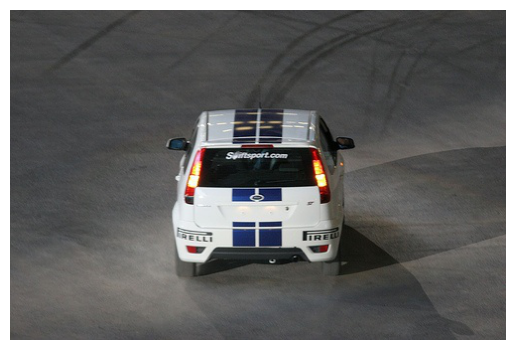

In [ ]:
show_image(ds[0][0]);

In [ ]:
ds[0][1]['annotation']['object']

[{'name': 'car',
  'pose': 'Rear',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]

In [ ]:
ds[0][1]['annotation']['object'][0]['name']

'car'

In [ ]:
len(ds)

2501

### Checking out data

In [ ]:
def show_voc_sample(ds, idx, figsize=(12,10)):
    img, target = ds[idx]
    objects = target['annotation']['object']
    img_array = np.array(img)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_array)
    width = int(target['annotation']['size']['width'])
    height = int(target['annotation']['size']['height'])
    for obj in objects:
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])
        rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin-5, obj['name'], 
                bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')
    ax.set_title(f"Image {idx}: {', '.join([obj['name'] for obj in objects])}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Image size: {width}x{height}")
    print(f"Number of objects: {len(objects)}")
    for i, obj in enumerate(objects):
        print(f"Object {i+1}: {obj['name']}, Difficult: {obj['difficult']}, Truncated: {obj['truncated']}")

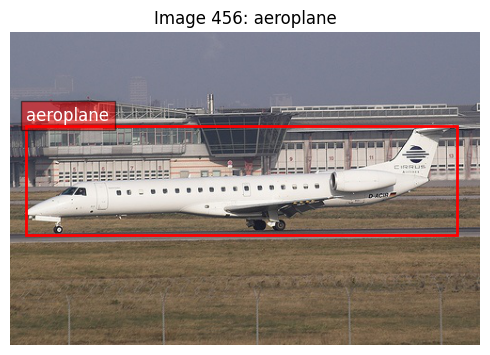

Image size: 500x333
Number of objects: 1
Object 1: aeroplane, Difficult: 0, Truncated: 0


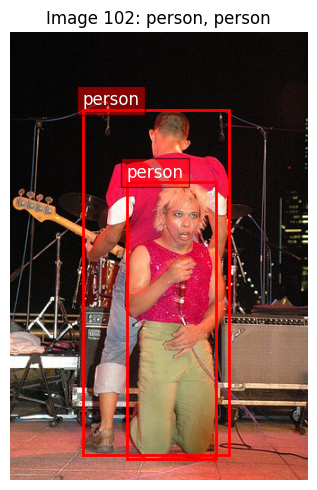

Image size: 332x500
Number of objects: 2
Object 1: person, Difficult: 0, Truncated: 0
Object 2: person, Difficult: 0, Truncated: 0


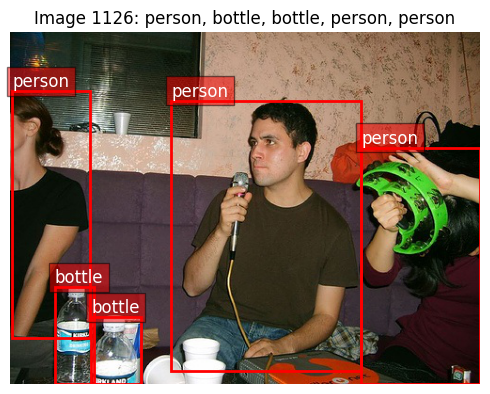

Image size: 500x375
Number of objects: 5
Object 1: person, Difficult: 0, Truncated: 1
Object 2: bottle, Difficult: 0, Truncated: 1
Object 3: bottle, Difficult: 0, Truncated: 1
Object 4: person, Difficult: 0, Truncated: 1
Object 5: person, Difficult: 0, Truncated: 1


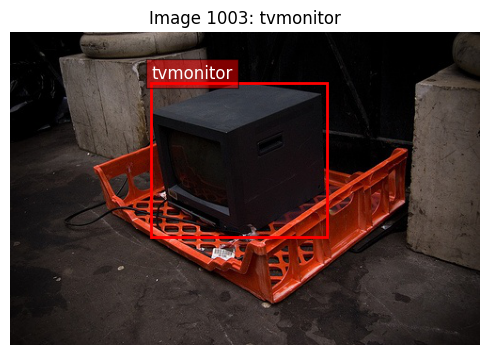

Image size: 500x333
Number of objects: 1
Object 1: tvmonitor, Difficult: 0, Truncated: 0


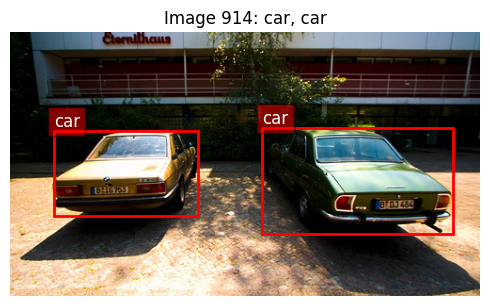

Image size: 500x281
Number of objects: 2
Object 1: car, Difficult: 0, Truncated: 0
Object 2: car, Difficult: 0, Truncated: 0


In [ ]:
set_seed(42)
import random
random_indices = random.sample(range(len(ds)), 5)
for idx in random_indices:
    show_voc_sample(ds, idx, figsize=(5,5))

In [ ]:
def get_class_distribution(ds):
    "Get distribution of classes in the dataset"
    counts = {}
    for i in range(len(ds)):
        img, target = ds[i]
        for obj in target['annotation']['object']:
            cls = obj['name']
            counts[cls] = counts.get(cls, 0) + 1
    return pd.Series(counts).sort_values(ascending=False)

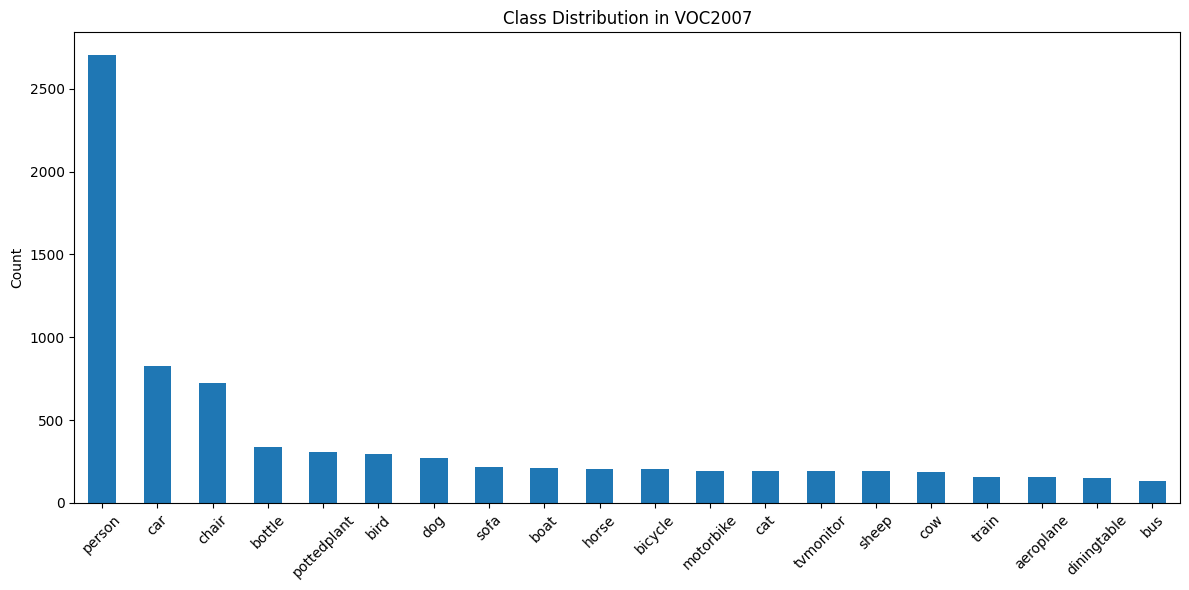

In [ ]:
class_dist = get_class_distribution(ds)
plt.figure(figsize=(12, 6))
class_dist.plot(kind='bar')
plt.title('Class Distribution in VOC2007')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
def get_image_sizes(ds, n=100):
    "Get distribution of image sizes in the dataset"
    sizes = []
    for i in range(min(n, len(ds))):
        img, _ = ds[i]
        sizes.append(img.size)
    return pd.DataFrame(sizes, columns=['width', 'height'])

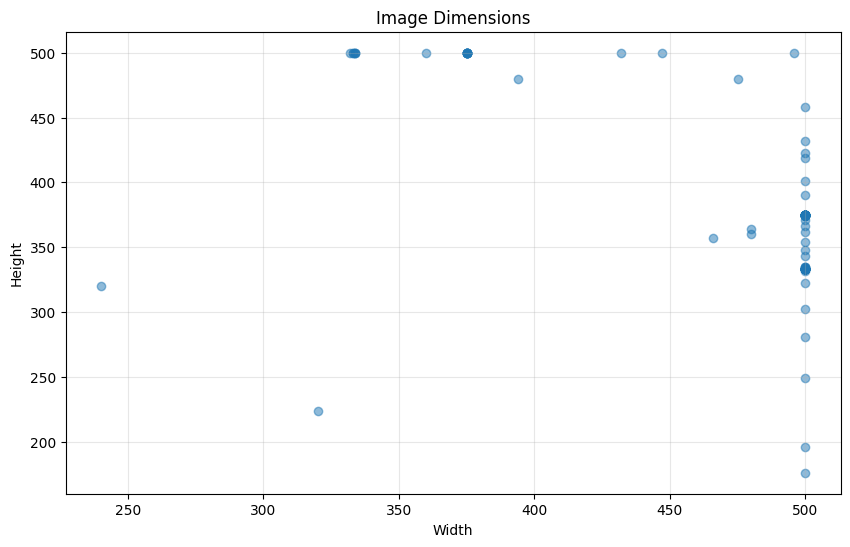

In [ ]:
sizes = get_image_sizes(ds)
plt.figure(figsize=(10, 6))
plt.scatter(sizes['width'], sizes['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True, alpha=0.3)

In [ ]:
def show_class_examples(ds, class_name, n=4):
    "Show examples of a specific class"
    examples = []
    for i in range(len(ds)):
        img, target = ds[i]
        if any(obj['name'] == class_name for obj in target['annotation']['object']):
            examples.append((img, target))
            if len(examples) >= n: break
    
    fig, axes = subplots(1, n, figsize=(n*4, 4))
    for i, (img, target) in enumerate(examples):
        axes[i].imshow(img)
        axes[i].set_title(f"Example {i+1}")
        axes[i].axis('off')
        
        for obj in target['annotation']['object']:
            if obj['name'] == class_name:
                bbox = obj['bndbox']
                x1, y1 = int(bbox['xmin']), int(bbox['ymin'])
                x2, y2 = int(bbox['xmax']), int(bbox['ymax'])
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   fill=False, edgecolor='green', linewidth=2)
                axes[i].add_patch(rect)
    
    plt.suptitle(f"Examples of '{class_name}'")
    plt.tight_layout()
    return fig

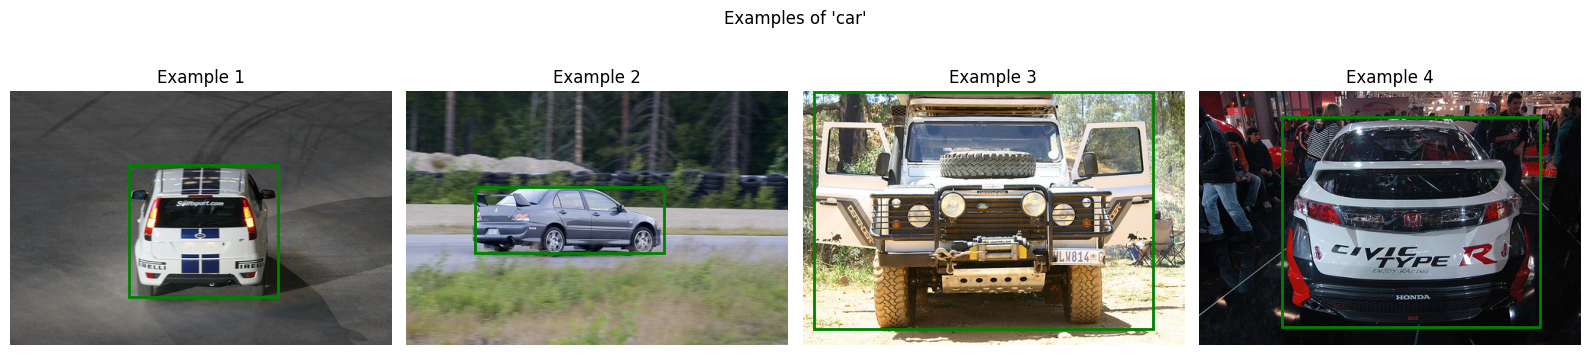

In [ ]:
show_class_examples(ds, 'car');

Text(0, 0.5, 'Number of Images')

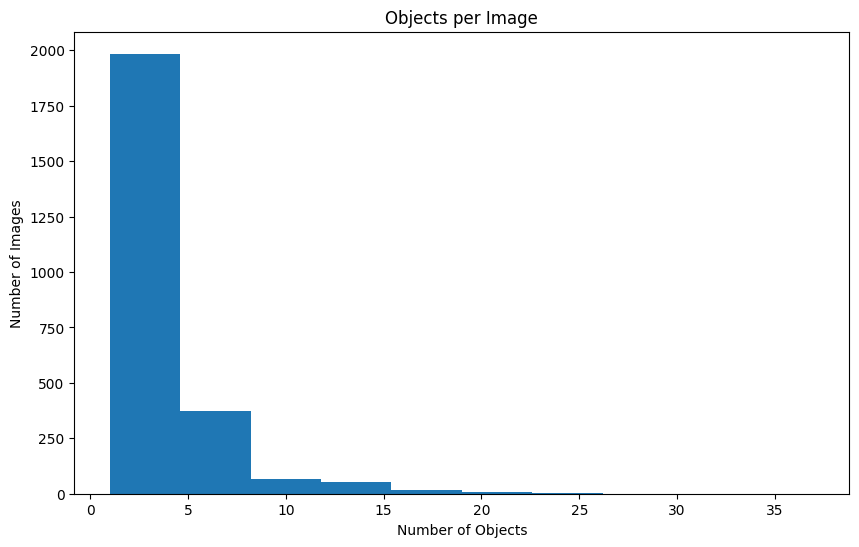

In [ ]:
objects_per_image = [len(ds[i][1]['annotation']['object']) for i in range(len(ds))]
plt.figure(figsize=(10, 6))
plt.hist(objects_per_image, bins=10)
plt.title('Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')

### Dataset

In [ ]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_files = list(Path(image_dir).glob('*.nd2'))
        self.transform = transform
        
    def __len__(self): return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = get_im(img_path)
        label_path = img_path.with_suffix('.csv')
        corners = calc_corners(str(label_path))
        
        if self.transform:
            img = self.transform(img)
            
        return img, corners

In [ ]:
class VOCDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', image_set='train', year='2007'):
        self.dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transforms.Compose([
            transforms.Resize((416, 416)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = self.transform(img)
        
        # Extract bounding boxes and classes
        boxes = []
        classes = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            # Convert to [x1, y1, x2, y2]
            box = [
                float(bbox['xmin']), float(bbox['ymin']),
                float(bbox['xmax']), float(bbox['ymax'])
            ]
            boxes.append(box)
            classes.append(VOC_CLASSES.index(obj['name']))
            
        return img, {'boxes': torch.tensor(boxes), 'labels': torch.tensor(classes)}

In [ ]:
# 1. Create detection model
class YOLODetector(nn.Module):
    def __init__(self, num_classes=20, num_anchors=5):
        super().__init__()
        self.backbone = get_darknet19()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        
        # Detection head
        self.detector = nn.Sequential(
            ConvBlock(1024, 1024),
            nn.Conv2d(1024, num_anchors * (5 + num_classes), kernel_size=1)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.detector(x)
        
    def get_boxes(self, output, anchors, conf_threshold=0.5):
        # Process network output to get boxes
        batch_size, _, grid_size, _ = output.shape
        output = output.view(batch_size, self.num_anchors, 5 + self.num_classes, grid_size, grid_size)
        output = output.permute(0, 1, 3, 4, 2).contiguous()
        
        # Apply sigmoid to xy, objectness and class scores
        output[..., 0:2] = torch.sigmoid(output[..., 0:2])  # xy
        output[..., 4:] = torch.sigmoid(output[..., 4:])    # objectness + classes
        
        # Process predictions
        boxes = []
        for i in range(batch_size):
            # Get boxes with objectness > threshold
            pred = output[i]
            mask = pred[..., 4] > conf_threshold
            pred = pred[mask]
            
            if len(pred) == 0:
                boxes.append([])
                continue
                
            # Convert predictions to boxes [x, y, w, h, obj, class_id, class_prob]
            box_pred = pred[..., :5].clone()
            class_pred = pred[..., 5:]
            
            # Get class with highest probability
            class_scores, class_ids = torch.max(class_pred, dim=1)
            box_pred = torch.cat([box_pred, class_ids.float().unsqueeze(1), class_scores.unsqueeze(1)], dim=1)
            
            # Convert to [x1, y1, x2, y2, obj, class_id, class_prob]
            boxes.append(box_pred)
            
        return boxes

# 2. Custom dataset for bounding boxes
class VOCDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', image_set='train', year='2007'):
        self.dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transforms.Compose([
            transforms.Resize((416, 416)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = self.transform(img)
        
        # Extract bounding boxes and classes
        boxes = []
        classes = []
        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            # Convert to [x1, y1, x2, y2]
            box = [
                float(bbox['xmin']), float(bbox['ymin']),
                float(bbox['xmax']), float(bbox['ymax'])
            ]
            boxes.append(box)
            classes.append(VOC_CLASSES.index(obj['name']))
            
        return img, {'boxes': torch.tensor(boxes), 'labels': torch.tensor(classes)}

In [ ]:
def create_voc_datasets(data_path, train_tfms=None, valid_tfms=None, year='2007'):
    "Create training and validation datasets for VOC"
    if train_tfms is None:
        train_tfms = v2.Compose([
            v2.RandomResizedCrop(224),
            v2.RandomHorizontalFlip(),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    if valid_tfms is None:
        valid_tfms = v2.Compose([
            v2.Resize(256),
            v2.CenterCrop(224),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    train_ds = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False,
                                    transform=train_tfms)
    valid_ds = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False,
                                   transform=valid_tfms)
    return train_ds, valid_ds

def voc_collate_fn(batch):
    "Custom collate function for VOC dataset that handles images and targets"
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        objects = target['annotation']['object']
        label = torch.zeros(len(VOC_CLASSES))
        for obj in objects:
            class_idx = VOC_CLASSES.index(obj['name'])
            label[class_idx] = 1
        
        targets.append(label)
    
    images = torch.stack(images)
    targets = torch.stack(targets)
    return images, targets

def get_voc_dls(data_path, bs=16, year='2007', num_workers=4):
    "Create dataloaders for VOC dataset"
    train_ds, valid_ds = create_voc_datasets(data_path, year=year)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, 
                         collate_fn=voc_collate_fn, num_workers=num_workers)
    valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False, 
                         collate_fn=voc_collate_fn, num_workers=num_workers)
    return DataLoaders(train_dl, valid_dl)


In [ ]:
class VOCClassificationDataset(Dataset):
    "Dataset for VOC classification (multi-label)"
    def __init__(self, voc_ds):
        self.voc_ds = voc_ds
        
    def __len__(self):
        return len(self.voc_ds)
    
    def __getitem__(self, idx):
        img, target = self.voc_ds[idx]
        
        objects = target['annotation']['object']
        label = torch.zeros(len(VOC_CLASSES))
        for obj in objects:
            class_idx = VOC_CLASSES.index(obj['name'])
            label[class_idx] = 1
        
        return img, label

In [ ]:
def create_voc_tfm_datasets(data_path, year='2007'):
    "Create TfmDataset for VOC"
    train_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False)
    valid_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False)
    
    train_ds = VOCClassificationDataset(train_ds_raw)
    valid_ds = VOCClassificationDataset(valid_ds_raw)
    
    train_tfms = v2.Compose([
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    valid_tfms = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_tfm_ds = TfmDataset(train_ds.voc_ds, train_ds.voc_ds, tfm_x=train_tfms)
    valid_tfm_ds = TfmDataset(valid_ds.voc_ds, valid_ds.voc_ds, tfm_x=valid_tfms)
    
    return train_tfm_ds, valid_tfm_ds

Denormalize image before display

In [ ]:
?v2.ToDtype

In [ ]:
from torch import tensor

xmean,xstd = (tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225]))
xmean.shape

torch.Size([3])

In [ ]:
xmean[:,None,None].shape

torch.Size([3, 1, 1])

In [ ]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

In [ ]:
def get_voc_dls_minai(data_path, bs=16, year='2007'):
    "Create dataloaders using minai's get_dls function"
    train_ds, valid_ds = create_voc_tfm_datasets(data_path, year=year)
    return get_dls(train_ds, valid_ds, bs=bs, collate_fn=voc_collate_fn)

In [ ]:
trn_ds, vld_ds = create_voc_tfm_datasets(data_path)
trn_ds[0]

((Image([[[-0.7822, -0.7822, -0.7822,  ..., -0.6109, -0.5767, -0.5424],
          [-0.8335, -0.8164, -0.8164,  ..., -0.5424, -0.4911, -0.5767],
          [-0.8164, -0.8164, -0.7993,  ..., -0.5253, -0.4911, -0.4911],
          ...,
          [-0.5938, -0.6281, -0.6281,  ..., -0.9192, -0.8678, -0.7822],
          [-0.6281, -0.6109, -0.6109,  ..., -0.8507, -0.9363, -0.8507],
          [-0.6452, -0.6794, -0.6794,  ..., -0.8164, -0.9192, -0.9192]],
  
         [[-0.6527, -0.6527, -0.6527,  ..., -0.5651, -0.5301, -0.4776],
          [-0.7052, -0.6877, -0.6877,  ..., -0.4776, -0.4251, -0.5126],
          [-0.7052, -0.7052, -0.6877,  ..., -0.4251, -0.3901, -0.4076],
          ...,
          [-0.4776, -0.5126, -0.5126,  ..., -0.8102, -0.7577, -0.6702],
          [-0.5126, -0.4951, -0.4951,  ..., -0.7402, -0.8277, -0.7402],
          [-0.5301, -0.5651, -0.5651,  ..., -0.7052, -0.8102, -0.8102]],
  
         [[-0.5147, -0.5147, -0.5147,  ..., -0.3927, -0.3578, -0.3404],
          [-0.5670, -0.549

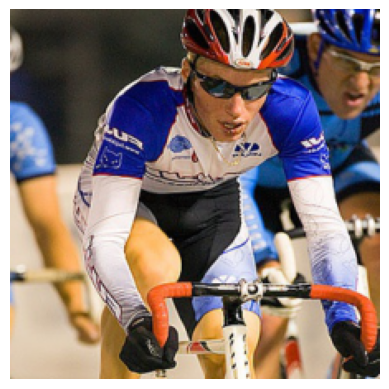

In [ ]:
show_image(denorm(trn_ds[2][0][0]));

### DataLoader

Batch shape: torch.Size([16, 3, 224, 224]), Labels shape: torch.Size([16, 20])
Average labels per image: 1.69
Most common classes: ['person', 'car', 'horse', 'bird', 'cat']


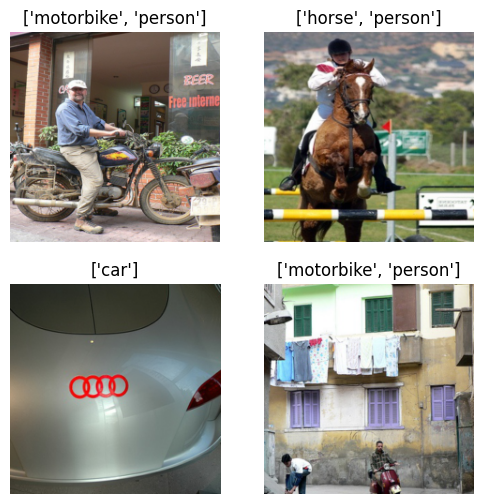

In [ ]:
dls = get_voc_dls(data_path, bs=16)

dls_minai = get_voc_dls_minai(data_path, bs=16)

xb, yb = next(iter(dls.train))
# xb, yb = next(iter(dls_minai[0]))
print(f"Batch shape: {xb.shape}, Labels shape: {yb.shape}")

print(f"Average labels per image: {yb.sum(dim=1).mean().item():.2f}")
print(f"Most common classes: {[VOC_CLASSES[i] for i in yb.sum(dim=0).argsort(descending=True)[:5]]}")

idxs = torch.randint(0, len(xb), (4,))
show_images(
    [TF.to_pil_image(denorm(img)) for img in xb[idxs]], 
    titles=[[VOC_CLASSES[i] for i in torch.where(lbl == 1)[0]] for lbl in yb[idxs]]
)

## Training Classification

In [ ]:
import torch.nn.functional as F

In [ ]:
def get_classification_model(num_classes=len(VOC_CLASSES)):
    "Create a multi-label classification model based on darknet19"
    backbone = get_darknet19()
    model = nn.Sequential(
        backbone,
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

def multi_label_loss(preds, targets):
    return F.binary_cross_entropy_with_logits(preds, targets)

model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-3, 
                   cbs=[TrainCB(), DeviceCB(), ProgressCB(), MetricsCB()])

In [ ]:
learn.summary()

Tot params: 20359636; MFLOPS: 970.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(16, 3, 224, 224)|(16, 1024, 7, 7)|19824576|970.4|
|AdaptiveAvgPool2d|(16, 1024, 7, 7)|(16, 1024, 1, 1)|0|0.0|
|Flatten|(16, 1024, 1, 1)|(16, 1024)|0|0.0|
|Linear|(16, 1024)|(16, 512)|524800|0.5|
|ReLU|(16, 512)|(16, 512)|0|0.0|
|Dropout|(16, 512)|(16, 512)|0|0.0|
|Linear|(16, 512)|(16, 20)|10260|0.0|


In [ ]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, denorm=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    xb,yb = to_cpu(self.batch)
    feat = fc.nested_attr(self.dls, 'train.dataset.features')
    denorm = denorm if denorm else fc.noop
    if feat is None: titles = np.array(to_cpu(yb))     # when fitting, yb is in GPU
    else:
        names = feat['label'].names
        titles = [names[i] for i in yb]
    show_images(denorm(xb[:max_n]), titles=titles[:max_n], **kwargs)

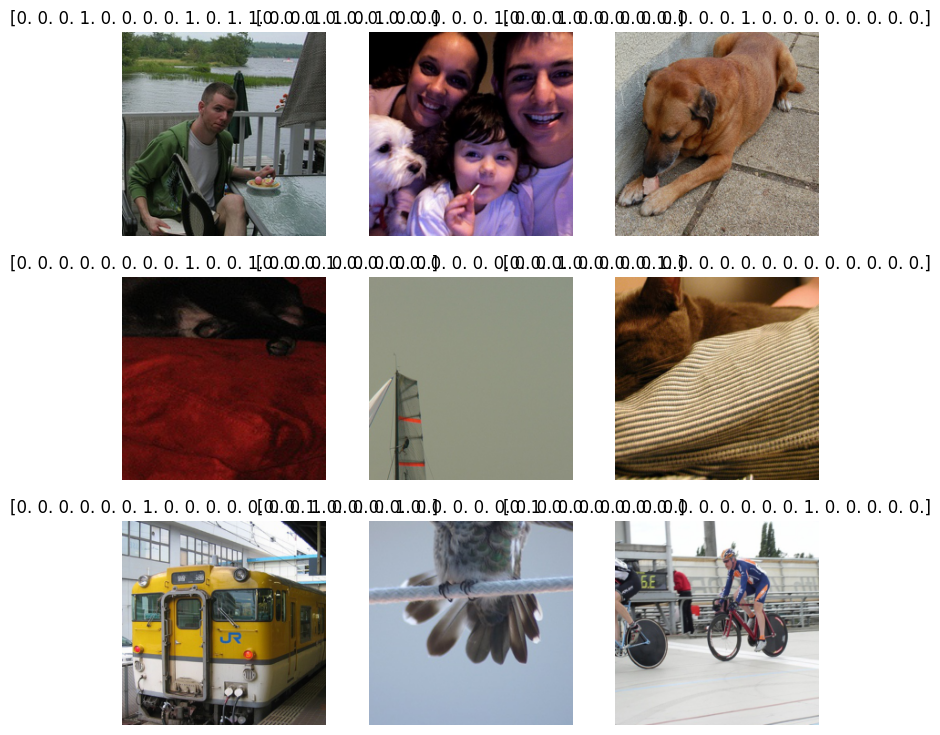

In [ ]:
learn.show_image_batch(denorm=denorm)

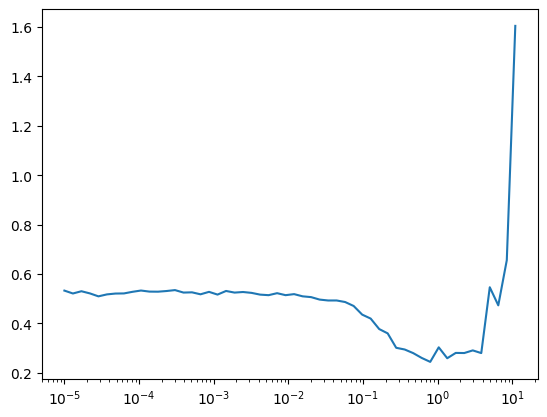

In [ ]:
learn.lr_find()

In [ ]:
model = get_classification_model()
learn = TrainLearner(model, dls, multi_label_loss, lr=1e-2, 
                   cbs=[DeviceCB(), ProgressCB(), MetricsCB()])
learn.fit(3)